#Titanic - Initial Data Exploration and model fitting

In [2]:
import numpy as np
import pandas as pd
%pylab inline
import seaborn as sns
from pandasql import sqldf
import matplotlib.pyplot as plt
from ggplot import *

pysqldf = lambda q: sqldf(q, globals())

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Read in training dataset
training_data = pd.read_csv('train.csv', sep = ',')

#fix column names to make life easier...
training_data.columns = ['id', 'survived', 'class', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']

#Display training data
training_data.head(n=10)

,id,survived,class,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


##Exploratory Data Analysis
Firstly a quick exploration of the key features and dimensions of the training data and a check for missing data

###Understanding the key question, how many passengers in the training set survived?

In [4]:
pd.DataFrame(training_data.groupby('survived').count()['id'])

,id
survived,
0,549
1,342


This means that of a total of 891 passengers, 62% did not survive. This forms the benchmark for our future predictions as if we had no information we could guess that a given passenger would not survive with an accuracy of 62% assuming that the training dataset is a good representation of the population.

In [5]:
print 'Data Frame of ' + str(training_data.shape[0]) + ' rows and ' + str(training_data.shape[1]) + ' columns'
training_data.count()

Data Frame of 891 rows and 12 columns


id          891
survived    891
class       891
name        891
sex         891
age         714
sibsp       891
parch       891
ticket      891
fare        891
cabin       204
embarked    889
dtype: int64

There are 3 variables that have missing data - Age, Cabin and Embarked. In the case of the latter 2, this likely means that this attribute didn't exist however for age it is clearly a missing value. Under different circumstances it might be prudent to remove these records from the dataset however given the small size of the dataset and the fact that predictions may be necessary on records that have the same problem, a strategy for imputing these values needs to be found.

###Plot below shows that passenger class and age are likely to be useful dimensions in being able to impute age more accurately.

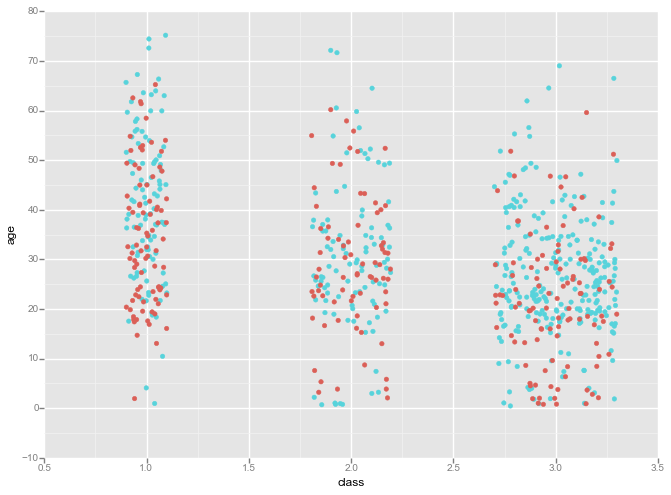

<ggplot: (283553461)>

In [6]:
plt.figure(figsize=(15, 4))
ggplot(aes(x = 'class', y = 'age', color = 'sex'), data = training_data) + geom_point(position = 'jitter')

In [7]:
ages = pd.DataFrame(training_data.groupby(['class', 'sex']).median()['age']).reset_index()
print 'Median ages of passengers by class and sex:'
ages

Median ages of passengers by class and sex:


,class,sex,age
0,1,female,35.0
1,1,male,40.0
2,2,female,28.0
3,2,male,30.0
4,3,female,21.5
5,3,male,25.0


###Use pandasql to join ages table to training data and impute the age where missing.

In [8]:
impute_ages_query = '''
SELECT
    t.id, 
    t.survived,
    t.class,
    t.name,
    t.sex,
    (CASE WHEN t.age > 0 THEN t.age ELSE a.age END) AS age,
    t.sibsp,
    t.parch,
    t.ticket,
    t.fare,
    t.cabin,
    t.embarked
FROM training_data t
LEFT JOIN ages a on a.class = t.class and a.sex = t.sex
'''
training_data = pysqldf(impute_ages_query)
training_data.head(n = 10)

,id,survived,class,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,None,S
5,6,0,3,"Moran, Mr. James",male,25,0,0,330877,8.4583,None,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,None,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,None,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,None,C


[(0, 200)]

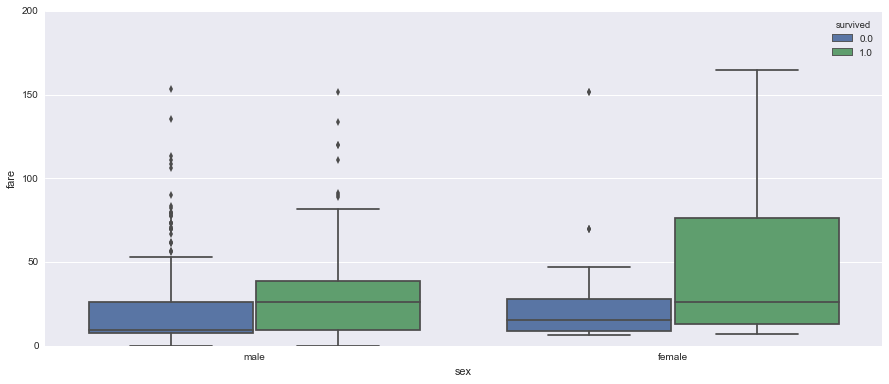

In [9]:
plt.figure(figsize=(15, 6))
ax = sns.boxplot(x = 'sex', y = 'fare', hue = 'survived', data = training_data)
ax.set(ylim=(0, 200))

[(0, 200)]

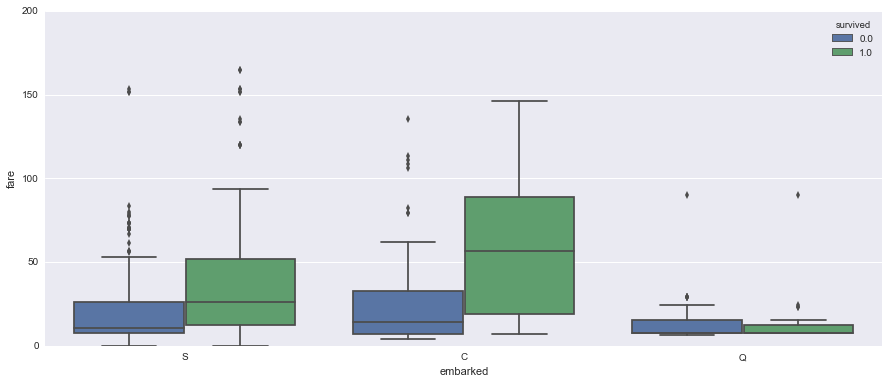

In [10]:
plt.figure(figsize=(15, 6))
ax = sns.boxplot(x = 'embarked', y = 'fare', hue = 'survived', data = training_data)
ax.set(ylim=(0, 200))

[(0, 200)]

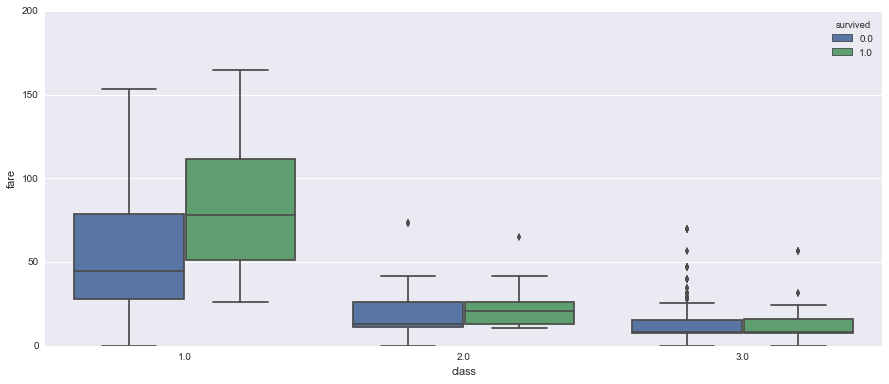

In [11]:
plt.figure(figsize=(15, 6))
ax = sns.boxplot(x = 'class', y = 'fare', hue = 'survived', data = training_data.sort(['survived', 'class']))
ax.set(ylim=(0, 200))

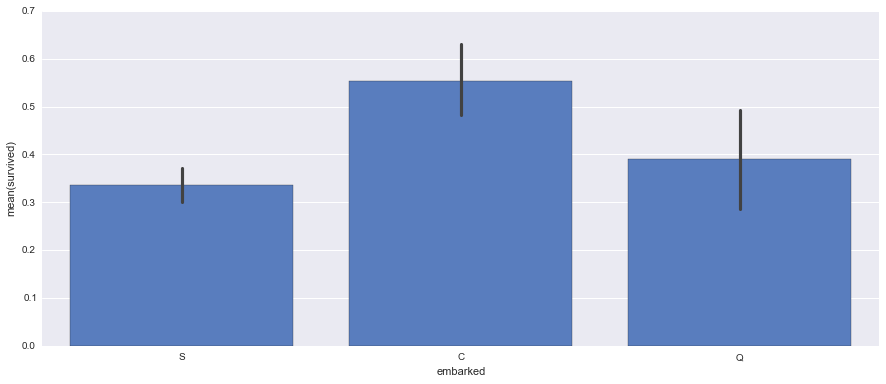

In [12]:
plt.figure(figsize=(15, 6))
sns.set_color_codes("muted")
sns.barplot(x="embarked", y="survived", data=training_data,
            label="survived", color="b")

Histogram of Fare Distribution

[(0, 200)]

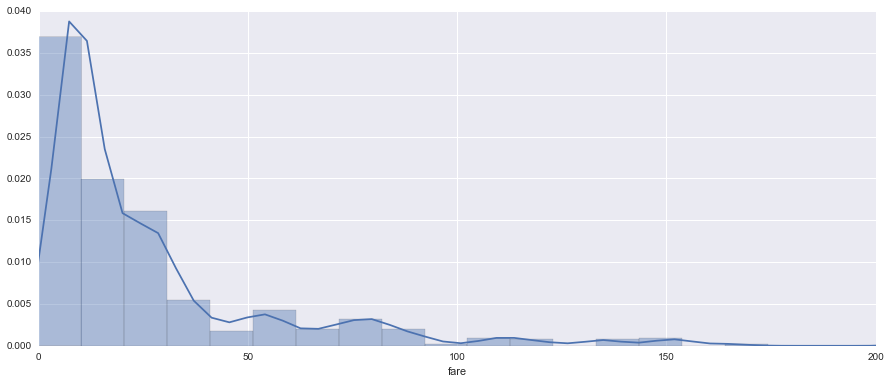

In [13]:
plt.figure(figsize=(15, 6))
ax = sns.distplot(training_data['fare'])
ax.set(xlim=(0, 200))

Add dummy variables for point of embarcation

In [13]:
training_data = pd.concat([training_data, pd.get_dummies(training_data['embarked'], prefix = 'embarked_at')], axis = 1)

Add dummy variables for sex

In [14]:
training_data = pd.concat([training_data, pd.get_dummies(training_data['sex'])], axis = 1)

In [15]:
def cabin_status(row):
    if row['cabin'] == None:
        return 0
    else:
        return 1
    
training_data['in_cabin'] = training_data.apply(cabin_status, axis = 1)    

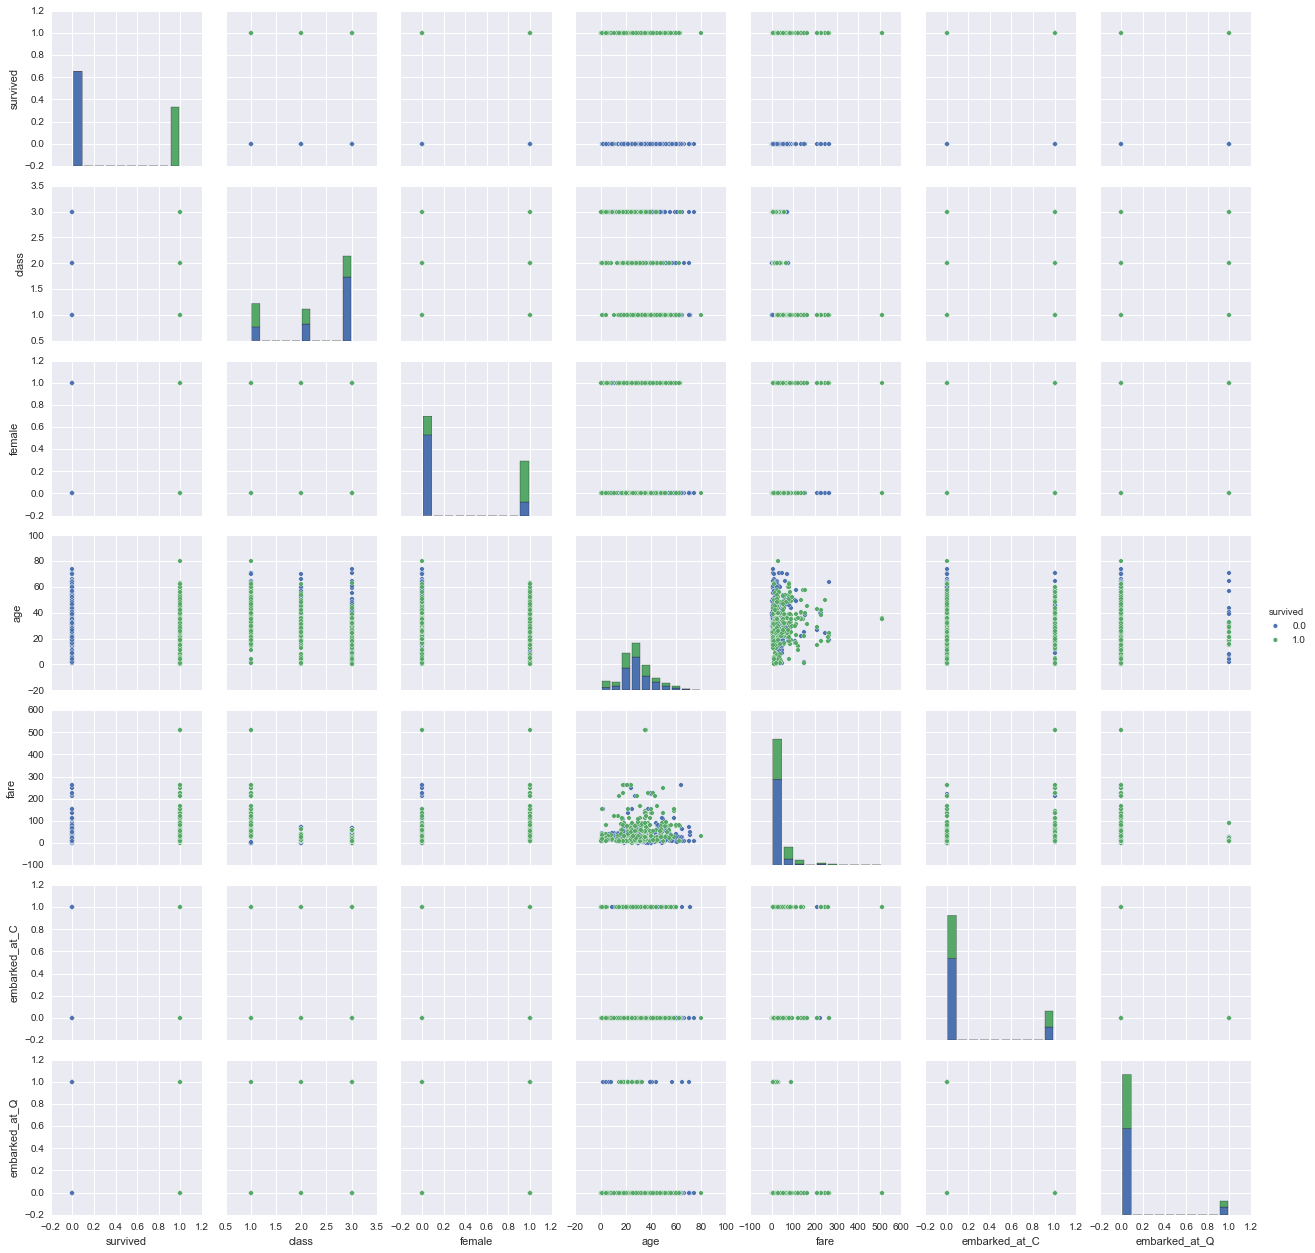

In [77]:
plt.figure(figsize=(15, 15))
sns.pairplot(training_data[['survived', 'class', 'female', 'age', 'fare', 'cabin', 'embarked_at_C', 'embarked_at_Q']], hue = 'survived')

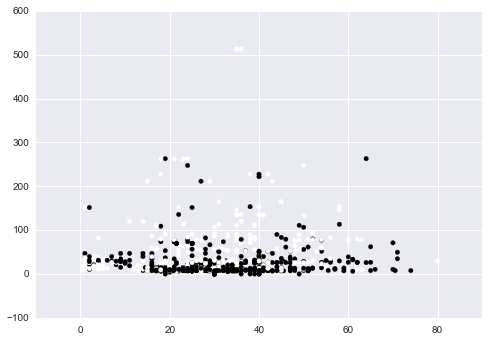

In [131]:
plt.scatter(training_data['age'], training_data['fare'], color = training_data['survived'].astype(str))

,id,survived,class,age,sibsp,parch,fare,embarked_at_C,embarked_at_Q,embarked_at_S,female,male,in_cabin,cluster
id,1.000000,-0.005007,-0.035144,0.039033,-0.057527,-0.001652,0.012658,-0.001205,-0.033606,0.022148,-0.042939,0.042939,0.019919,-0.053813
survived,-0.005007,1.000000,-0.338481,-0.059579,-0.035322,0.081629,0.257307,0.168240,0.003650,-0.155660,0.543351,-0.543351,0.316912,-0.091652
class,-0.035144,-0.338481,1.000000,-0.413583,0.083081,0.018443,-0.549500,-0.243292,0.221009,0.081720,-0.131900,0.131900,-0.725541,0.556355
age,0.039033,-0.059579,-0.413583,1.000000,-0.249854,-0.175526,0.122692,0.041114,-0.092418,0.014208,-0.102706,0.102706,0.277022,-0.500514
sibsp,-0.057527,-0.035322,0.083081,-0.249854,1.000000,0.414838,0.159651,-0.059528,-0.026354,0.070941,0.114631,-0.114631,-0.040460,0.451359
parch,-0.001652,0.081629,0.018443,-0.175526,0.414838,1.000000,0.216225,-0.011069,-0.081228,0.063036,0.245489,-0.245489,0.036987,0.507839
fare,0.012658,0.257307,-0.549500,0.122692,0.159651,0.216225,1.000000,0.269335,-0.117216,-0.166603,0.182333,-0.182333,0.482075,-0.236257
embarked_at_C,-0.001205,0.168240,-0.243292,0.041114,-0.059528,-0.011069,0.269335,1.000000,-0.148258,-0.778359,0.082853,-0.082853,0.208528,-0.257423
embarked_at_Q,-0.033606,0.003650,0.221009,-0.092418,-0.026354,-0.081228,-0.117216,-0.148258,1.000000,-0.496624,0.074115,-0.074115,-0.129572,0.316438
embarked_at_S,0.022148,-0.155660,0.081720,0.014208,0.070941,0.063036,-0.166603,-0.778359,-0.496624,1.000000,-0.125722,0.125722,-0.110087,0.032504


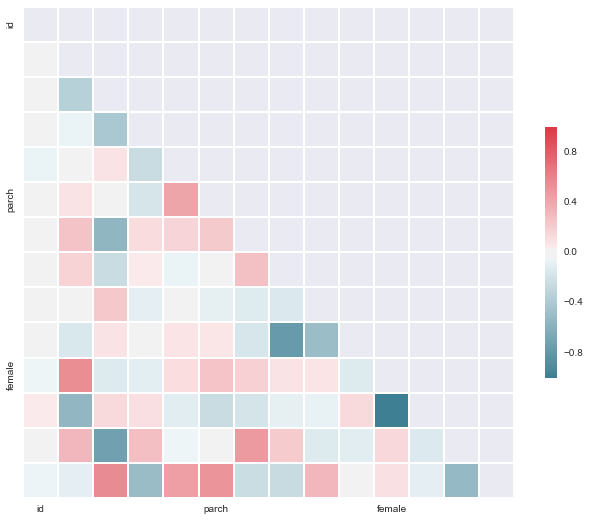

In [143]:
plt.figure(figsize=(15, 6))
corr = training_data.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

corr

##Cluster the passengers using K means

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

Grab relevant columns from dataset and standardise for Kmeans

In [19]:
X = training_data[['class', 'age', 'sibsp', 'parch', 'embarked_at_Q', 'embarked_at_S', 'in_cabin']].values
X = StandardScaler().fit_transform(X)
X

array([[ 0.82737724, -0.53489116,  0.43279337, ..., -0.30756234,
         0.61930636, -0.54492498],
       [-1.56610693,  0.66839176,  0.43279337, ..., -0.30756234,
        -1.61470971,  1.835115  ],
       [ 0.82737724, -0.23407043, -0.4745452 , ..., -0.30756234,
         0.61930636, -0.54492498],
       ..., 
       [ 0.82737724, -0.57249375,  0.43279337, ..., -0.30756234,
         0.61930636, -0.54492498],
       [-1.56610693, -0.23407043, -0.4745452 , ..., -0.30756234,
        -1.61470971,  1.835115  ],
       [ 0.82737724,  0.21716066, -0.4745452 , ...,  3.25137334,
        -1.61470971, -0.54492498]])

In [20]:
inertia = []
silh = []
cluster_ct = []
for i in range(2,20):
    k = KMeans(n_clusters = i)
    clusters = k.fit(X)
    inertia.append(clusters.inertia_)
    silh.append(silhouette_score(X, clusters.labels_))
    cluster_ct.append(i)

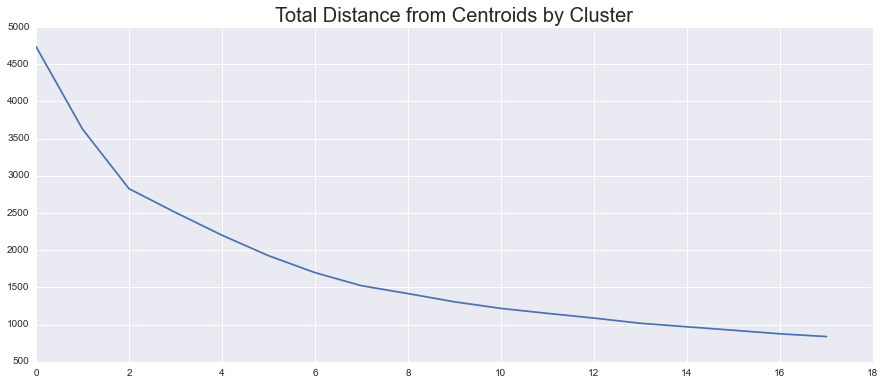

In [21]:
plt.figure(figsize=(15, 6))
plt.plot(inertia)
plt.title('Total Distance from Centroids by Cluster', fontsize = 20)

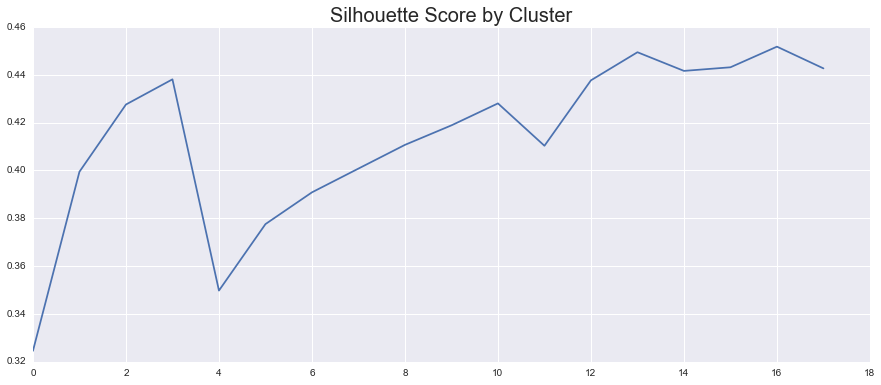

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(silh)
plt.title('Silhouette Score by Cluster', fontsize = 20)

Both charts above suggest that the number optimal number of clusters may be found on the second loop of the process which equates to 4 clusters. The relatively low silhouette scores suggest that the clustering may not yield many additional insights. 

In [23]:
k = KMeans(n_clusters = 4)
final_clusters = k.fit(X).labels_
final_clusters = pd.DataFrame(final_clusters)
final_clusters.columns = ['cluster']

In [24]:
training_data = pd.concat([training_data, final_clusters], axis = 1)

...do some exploration of clusters.......

**PCA**

In [90]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, n_components=2, whiten=False)

In [94]:
print(pca.explained_variance_ratio_)

[ 0.93395437  0.06581146]


In [113]:
X_alt = pd.DataFrame(pca.fit_transform(X))

In [120]:
training_data['survived']

0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     1
23     1
24     0
25     1
26     0
27     0
28     1
29     0
      ..
861    0
862    1
863    0
864    0
865    1
866    1
867    0
868    0
869    1
870    0
871    1
872    0
873    0
874    1
875    1
876    0
877    0
878    0
879    1
880    1
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: survived, dtype: float64

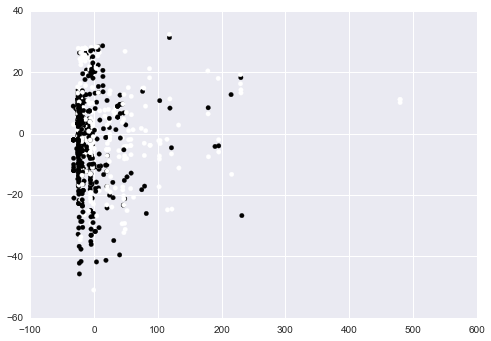

In [122]:
plt.scatter(X_alt[0], X_alt[1], color = training_data['survived'].astype(str))

##Fit some simple models



In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import cross_validation, tree, metrics, svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB 
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import classification_report

**Create dataset of key features for prediction**

In [211]:
X = training_data[['class', 'female', 'age', 'fare']].values
y = training_data['survived'].values
cv = KFold(n = X.shape[0], n_folds = 3, random_state =5)

**Logistic Regression**

In [154]:
log_reg = LogisticRegression()
scores = cross_validation.cross_val_score(log_reg, X, y, cv=cv)
print 'Out of fold prediction accuracy: ' + str(round(average(scores), 2))

Out of fold prediction accuracy: 0.79


**Decision Tree**

In [212]:
dt = tree.DecisionTreeClassifier()
dt.set_params(min_samples_leaf = 5)
dt.set_params(max_depth = 5)
scores = cross_validation.cross_val_score(dt, X, y, cv=cv)
print 'Out of fold prediction accuracy: ' + str(round(average(scores), 2))

Out of fold prediction accuracy: 0.81


In [31]:
#use pydot
import StringIO

#install pydot
import pydot
import pyparsing

In [32]:
dt.fit(X, y)
dot_data = StringIO.StringIO()
tree.export_graphviz(dt, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf('dt.pdf')
print '\nimage created!'


image created!


**Naive Bayes**

In [156]:
gnb = GaussianNB()
scores = cross_validation.cross_val_score(gnb, X, y, cv=cv)
print 'Out of fold prediction accuracy: ' + str(round(average(scores), 2))

Out of fold prediction accuracy: 0.78


In [157]:
mnb = MultinomialNB()
scores = cross_validation.cross_val_score(mnb, X, y, cv=cv)
print 'Out of fold prediction accuracy: ' + str(round(average(scores), 2))

Out of fold prediction accuracy: 0.69


**K Nearest Neighbours**

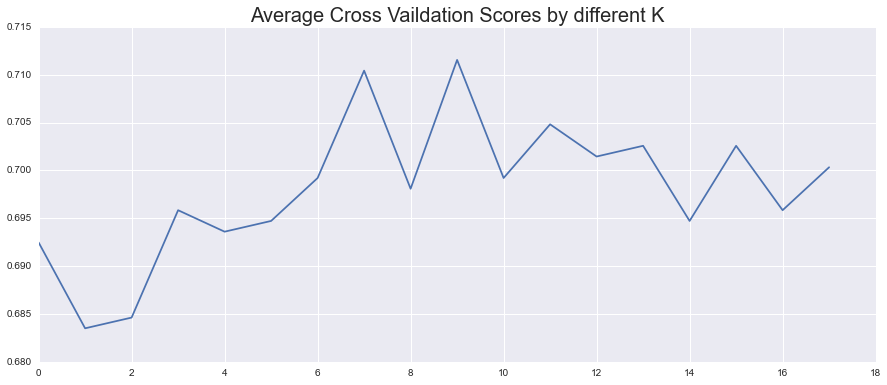

In [159]:
scores = []

for i in range(2,20):
    kn = KNeighborsClassifier(n_neighbors=i)
    scores.append(mean(cross_validation.cross_val_score(kn, X, y, cv = cv)))

plt.figure(figsize=(15, 6))
plt.plot(scores)
plt.title('Average Cross Vaildation Scores by different K', fontsize = 20)

Pretty poor results, lets try standardising the variables:

In [36]:
X_stand = StandardScaler().fit_transform(X)

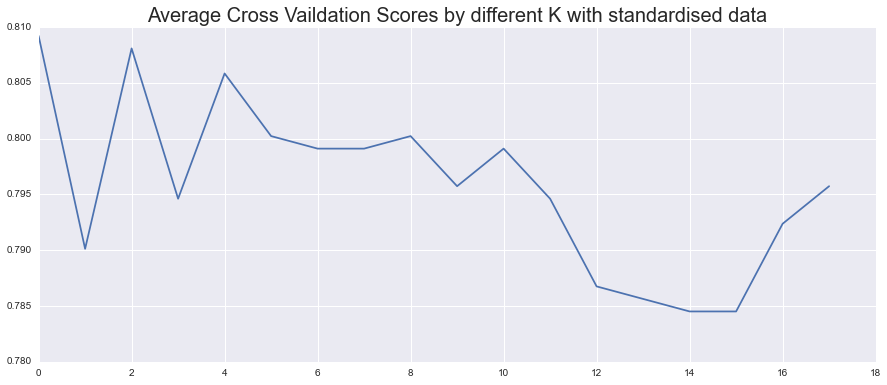

In [160]:
scores = []

for i in range(2,20):
    kn = KNeighborsClassifier(n_neighbors=i)
    scores.append(mean(cross_validation.cross_val_score(kn, X_stand, y, cv = cv)))

plt.figure(figsize=(15, 6))    
plt.plot(scores)
plt.title('Average Cross Vaildation Scores by different K with standardised data', fontsize = 20)

Much better!! More or less tops out on the 3rd loop which is k of 4.

**Support Vector Machine**

In [206]:
cv = KFold(n = X.shape[0], n_folds = 3, random_state =80)
sup = svm.SVC(kernel = 'rbf',gamma=0.8, C=5)
scores = cross_validation.cross_val_score(sup, X_stand, y, cv = cv)
print 'Out of fold prediction accuracy: ' + str(round(average(scores), 2))

Out of fold prediction accuracy: 0.8


**Bootstrapping Train/Test split on Logistic Regression**

In [208]:
scores = []
for rand in range(1, 10000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rand, test_size = 0.2) 
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_predicted = log_reg.predict(X_test)
    #print accuracy_score(y_test, y_predicted)
    scores.append(accuracy_score(y_test, y_predicted))
print 'average: ' + str(mean(scores))

average: 0.794456540626


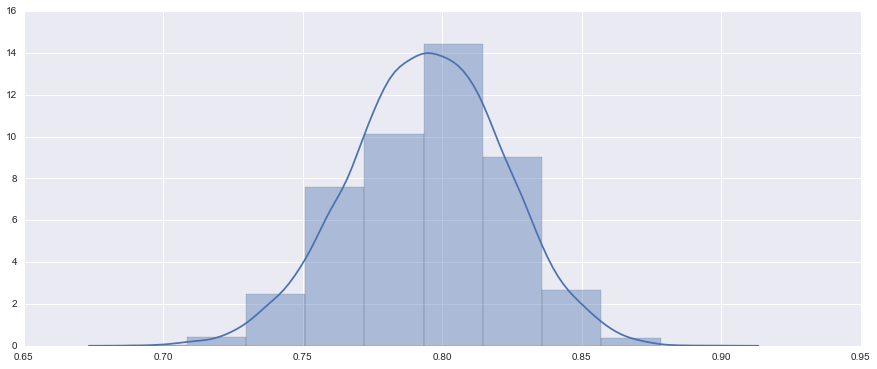

In [209]:
plt.figure(figsize=(15, 6))
ax = sns.distplot(scores, bins = 10)
#ax.set(xlim=(0, 200))

In [210]:
print 'Standard Deviation of: ' + str(round(std(scores), 4))

Standard Deviation of: 0.0275
